<a href="https://colab.research.google.com/github/Panaxnotoginseng/Exercise-3/blob/main/Exercise_3_Pinyin_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xpinyin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 3.3 MB/s eta 0:00:00


In [2]:
import re
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
from xpinyin import Pinyin
from tqdm import tqdm #for showing progress
p = Pinyin()

words = open('More Chinese Names.txt', 'r', encoding='utf-8-sig').read().splitlines() # read all the names
chars = sorted(list(set(''.join(p.get_pinyin((str(words))))))) # get the pinyin of each name, and then build a list of characters appeared and mappings to/from integers
stoi = {s:i+1 for i,s in enumerate(chars)} # assign a number to each character
stoi['.'] = 0 # assign 0 to dot
itos = {i:s for s,i in stoi.items()} #create a dictionary that contains all the characters and corresponding number
print(itos)

{1: ' ', 2: "'", 3: ',', 4: '-', 5: '[', 6: ']', 7: 'a', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'h', 15: 'i', 16: 'j', 17: 'k', 18: 'l', 19: 'm', 20: 'n', 21: 'o', 22: 'p', 23: 'q', 24: 'r', 25: 's', 26: 't', 27: 'u', 28: 'v', 29: 'w', 30: 'x', 31: 'y', 32: 'z', 0: '.'}


In [4]:
# build the dataset

block_size = 16 # Chinese names normally have no more than four characters,that would be around 16 letters in pinyin. Take 4 characters to make prediction can prevent generating extremely long names

X, Y = [], [] #X is the input of the neural network, Y is the label of each example in X
for w in p.get_pinyin((str(words))[:20]): # take 20 names
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context) # the running context
    Y.append(ix) # the index of X
    context = context[1:] + [ix] # crop the context and append a new character in the sequence

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, Y.shape) # from 20 names we get 102 examples (depending on name length). 16 input at each time.

torch.Size([102, 16]) torch.Size([102])


In [5]:
def build_dataset(words):
  X, Y = [], [] #X is the input of the neural network, Y is the label of each example in X
  for w in tqdm(words):
    context = [0] * block_size #initialize with all dots
    for ch in p.get_pinyin((str(w))[:20]) + '.':
      ix = stoi[ch]
      X.append(context) # the running context
      Y.append(ix) # the index of X
      context = context[1:] + [ix] # crop the context and append a new character in the sequence

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# separate datasets
Xtr, Ytr = build_dataset(words[:n1]) # training set
Xdev, Ydev = build_dataset(words[n1:n2]) # validation set
Xte, Yte = build_dataset(words[n2:]) #test set

100%|██████████| 80000/80000 [00:04<00:00, 16539.90it/s]


torch.Size([979939, 16]) torch.Size([979939])


100%|██████████| 10000/10000 [00:00<00:00, 49099.49it/s]


torch.Size([122465, 16]) torch.Size([122465])


100%|██████████| 10000/10000 [00:00<00:00, 29799.63it/s]


torch.Size([122669, 16]) torch.Size([122669])


In [6]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((33, 4), generator=g) # embed 33 different characters in 4 dimentional space
W1 = torch.randn((64, 200), generator=g) #set hidden layer with 64 inputs and 200 neurons
b1 = torch.randn(200, generator=g) # set bias for the 200 neurons in hidden layer
W2 = torch.randn((200, 33), generator=g) #set output layer with 200 inputs and 33 neurons
b2 = torch.randn(33, generator=g) # set bias for the 33 neurons in output layer

parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True # make sure all parameters have gradient


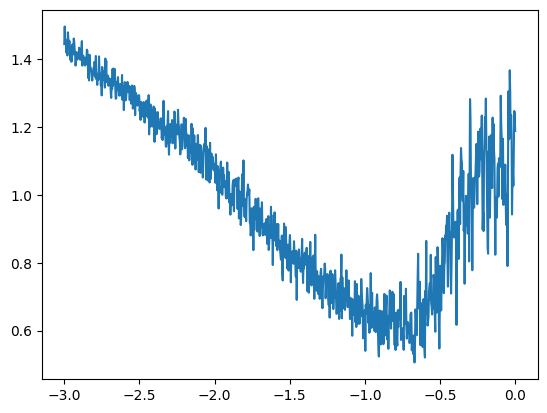

In [7]:
# find proper learning rate

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []


for i in range(1000):

  # construct minibatches of 100 examples
  ix = torch.randint(0, Xtr.shape[0], (100,))

  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 64) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None # set gradient to 0 every time
  loss.backward()

  # update parameters
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  #track status
  lri.append(lre[i])
  lossi.append(loss.log10().item())

plt.plot(lri,lossi) # exponent of the best learning rate is around -1, 10 to -1 is about 0.1

In [8]:
# training
for i in tqdm(range(300000)):

  # construct minibatches of 80 examples
  ix = torch.randint(0, Xtr.shape[0], (80,))

  # forward pass
  emb = C[Xtr[ix]] # (80, 4, 10)
  h = torch.tanh(emb.view(-1, 64) @ W1 + b1) # (80, 100)
  logits = h @ W2 + b2 # (80, 687) outcomes
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None # set gradient to 0 every time
  loss.backward()

  # update parameters
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

print(loss.item())

100%|██████████| 300000/300000 [05:03<00:00, 988.84it/s] 

1.290487289428711


In [9]:
# test on validation set
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 64) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss)

tensor(1.3255, grad_fn=<NllLossBackward0>)


In [10]:
# test on test set
emb = C[Xte]
h = torch.tanh(emb.view(-1, 64) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print(loss)

tensor(1.3210, grad_fn=<NllLossBackward0>)


In [11]:
!pip install Pinyin2Hanzi #convert the pinyin generated back to hanzi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Pinyin2Hanzi: filename=Pinyin2Hanzi-0.1.1-py3-none-any.whl size=6337725 sha256=31ecb94ba485ce6ac2c76e36889eb603590ba28aa9341b761d9f1db3f6940f9c
  Stored in directory: /root/.cache/pip/wheels/67/ee/bd/014c4ba22a6d72c4efe23d9c1fd848f8c3df7cff1994e95f23
Successfully built Pinyin2Hanzi


In [15]:
# generate names
import Pinyin2Hanzi
from Pinyin2Hanzi import simplify_pinyin, DefaultDagParams, dag

g = torch.Generator().manual_seed(214749787) # for reproducibility

dagparams = DefaultDagParams()

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all dots
    while True:
      emb = C[torch.tensor([context])] # (single example,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1) # normalized probability
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0: #generating a dot means the name ends
        break
    pystr = str(''.join(itos[i] for i in out))
    pystr = re.sub("\.", "", pystr) # delete the dot at the end
    print(pystr)# show all the generated pinyin, only acceptable pinyin would have a name in hanzi after
    pylist = pystr.split("-")
    for i in pylist:
      i = simplify_pinyin(i) # the method requires one pinyin at a time
    result = dag(dagparams, pylist, path_num=1)
    for item in result:
      print(''.join(item.path))

deng-jin-ping
等仅凭
lu-wen-cheng
炉温成
zhang-lia-jing
章俩经
mei-jia-hui
美甲会
zhang-muu-dao
hu-chen-hong
户沉红
pu-qi-ming
曝气名
li-di-ling
理低龄
xu-xi-zing
gu-jing-zheng
股竞争
liu-sheng-hong
留声红
liu-xi-shan
流锡山
chen-yin-jin
沉吟进
fang-fhun-qing
yu-yin
语音
wou-shengua
sun-jia-raa
li-chu-jian
理初见
xba-miao-qi
xu-shung-hing
